<a href="https://colab.research.google.com/github/subhamdash/deep-learning/blob/master/Selective_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Selective Search Install and RUN**

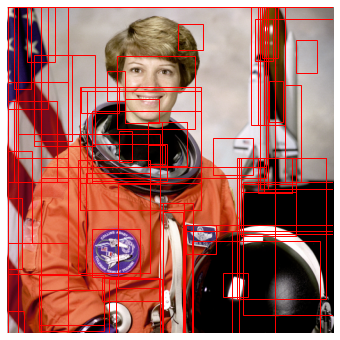

In [47]:
! pip install selective-search
import skimage
import selective_search

image = skimage.data.astronaut()

# Propose boxes
boxes = selective_search.selective_search(image, mode='single')

# Filter box proposals
boxes_filter = selective_search.box_filter(boxes, min_size=20, topN=80)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
for x1, y1, x2, y2 in boxes_filter:
    bbox = mpatches.Rectangle(
        (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(bbox)

plt.axis('off')
plt.show()

In [48]:
len(boxes_filter)

80

#**Selective Search From Scratch**

**Applying felzenszwalb algorithm**

In [0]:
from skimage.segmentation import felzenszwalb
import skimage
import matplotlib.pyplot as plt
image = skimage.data.astronaut()

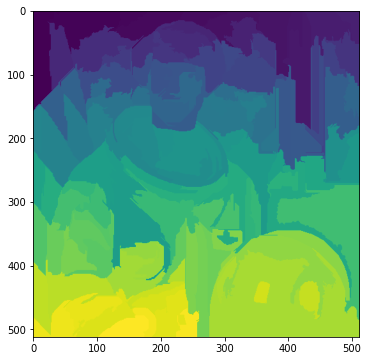

In [57]:
img_float = skimage.util.img_as_float(image)
img_seg = felzenszwalb(img_float, scale=3, sigma=0.8, min_size=500)
import numpy as np
img = np.dstack([image,img_seg])
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img[:,:,3])

**Extraction Of region**

In [58]:
from copy import copy
def extract_region(img):
    '''
    For each segmented region,
    extract smallest rectangle regions covering the smallest segmented region.
    
    == input ==
    img : (height, width, N channel)
          N channel = [R, G, B , L], L = label for the region
          only the L channel is used in this analysis 
    == output ==
    
    dictionary R :
    
    {0: {'labels': [0], 'max_x': 131, 'max_y': 74, 'min_x': 0,   'min_y': 0},
     1: {'labels': [1], 'max_x': 189, 'max_y': 37, 'min_x': 75,  'min_y': 0},
     2: {'labels': [2], 'max_x': 282, 'max_y': 38, 'min_x': 162, 'min_y': 0},
     3: {'labels': [3], 'max_x': 499, 'max_y': 23, 'min_x': 247, 'min_y': 0},
     4: {'labels': [4], 'max_x': 499, 'max_y': 74, 'min_x': 428, 'min_y': 13},
     5: {'labels': [5], 'max_x': 441, 'max_y': 76, 'min_x': 333, 'min_y': 16},
     6: {'labels': [6], 'max_x': 348, 'max_y': 80, 'min_x': 62,  'min_y': 21},
    '''
    ## only use the segmentation output
    img_segment = img[:,:,3]
    R = {}
    for y, i in enumerate(img_segment): ## along vertical axis 

        for x, l in enumerate(i): ## along horizontal axis
            # initialize a new region
            if l not in R:
                R[l] = {"min_x": np.Inf, 
                        "min_y": np.Inf,
                        "max_x": 0, 
                        "max_y": 0, 
                        "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y
    ## remove region if it does not have positive height or positive width
    
    Rcopy = copy(R)
    for key in R.keys():
        r = R[key]
        if (r["min_x"] == r["max_x"]) or (r["min_y"] == r["max_y"]):
            del Rcopy[key]
    return(Rcopy)
R = extract_region(img)
print("{} rectangle regions are found".format(len(R)))

115 rectangle regions are found


**Plotting the Rectangle**

In [0]:
import seaborn as sns
def plt_rectangle(plt,label,x1,y1,x2,y2,color = "red", alpha=0.5):
    linewidth = 1
    if type(label) == list:
        linewidth = 2
        label = ""
        
    plt.text(x1,y1,label,fontsize=20,backgroundcolor=color,alpha=alpha)
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color, alpha=alpha)


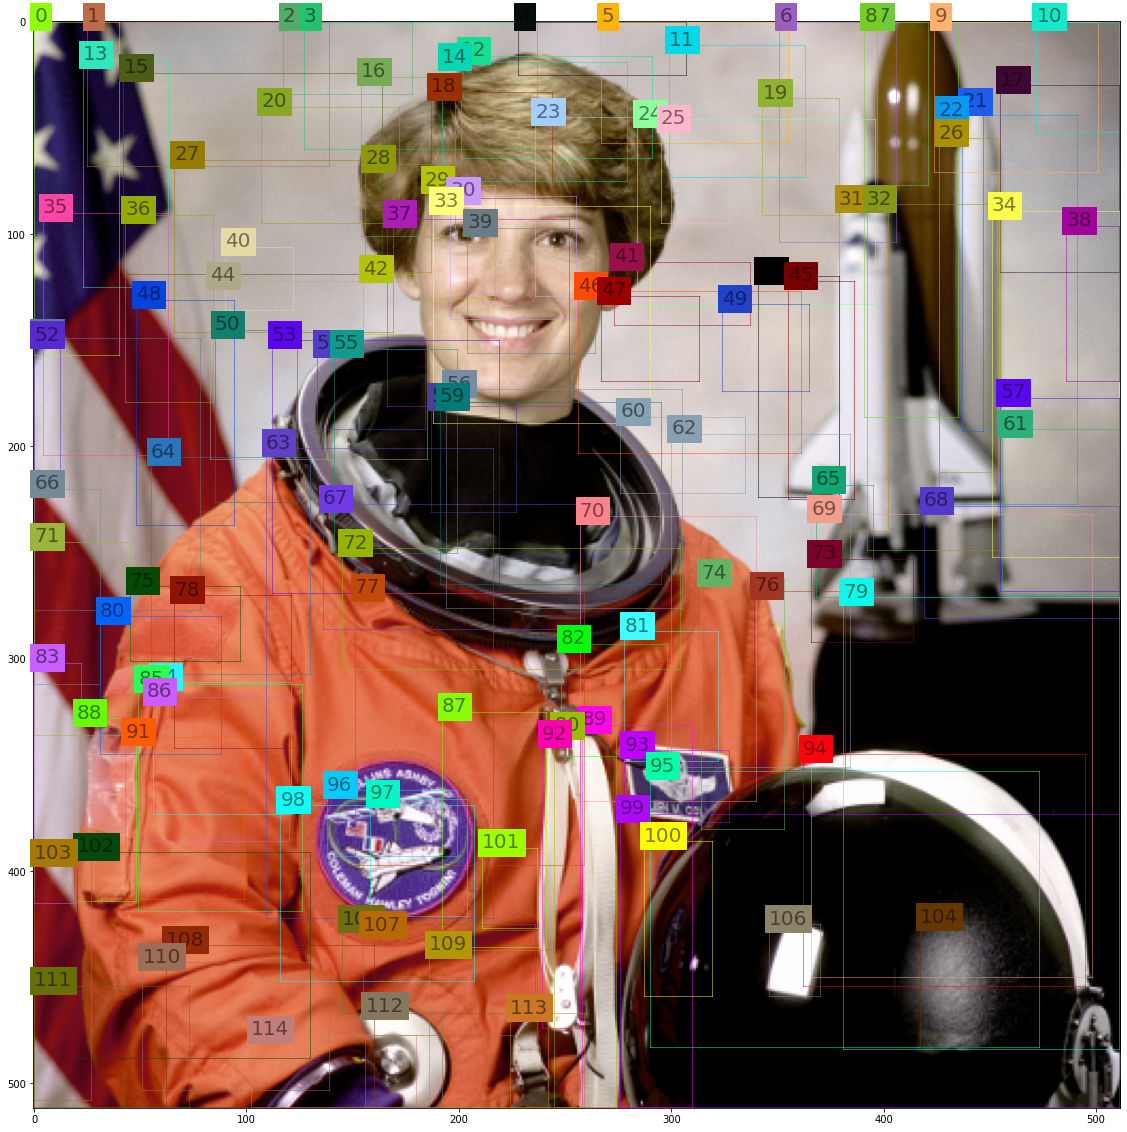

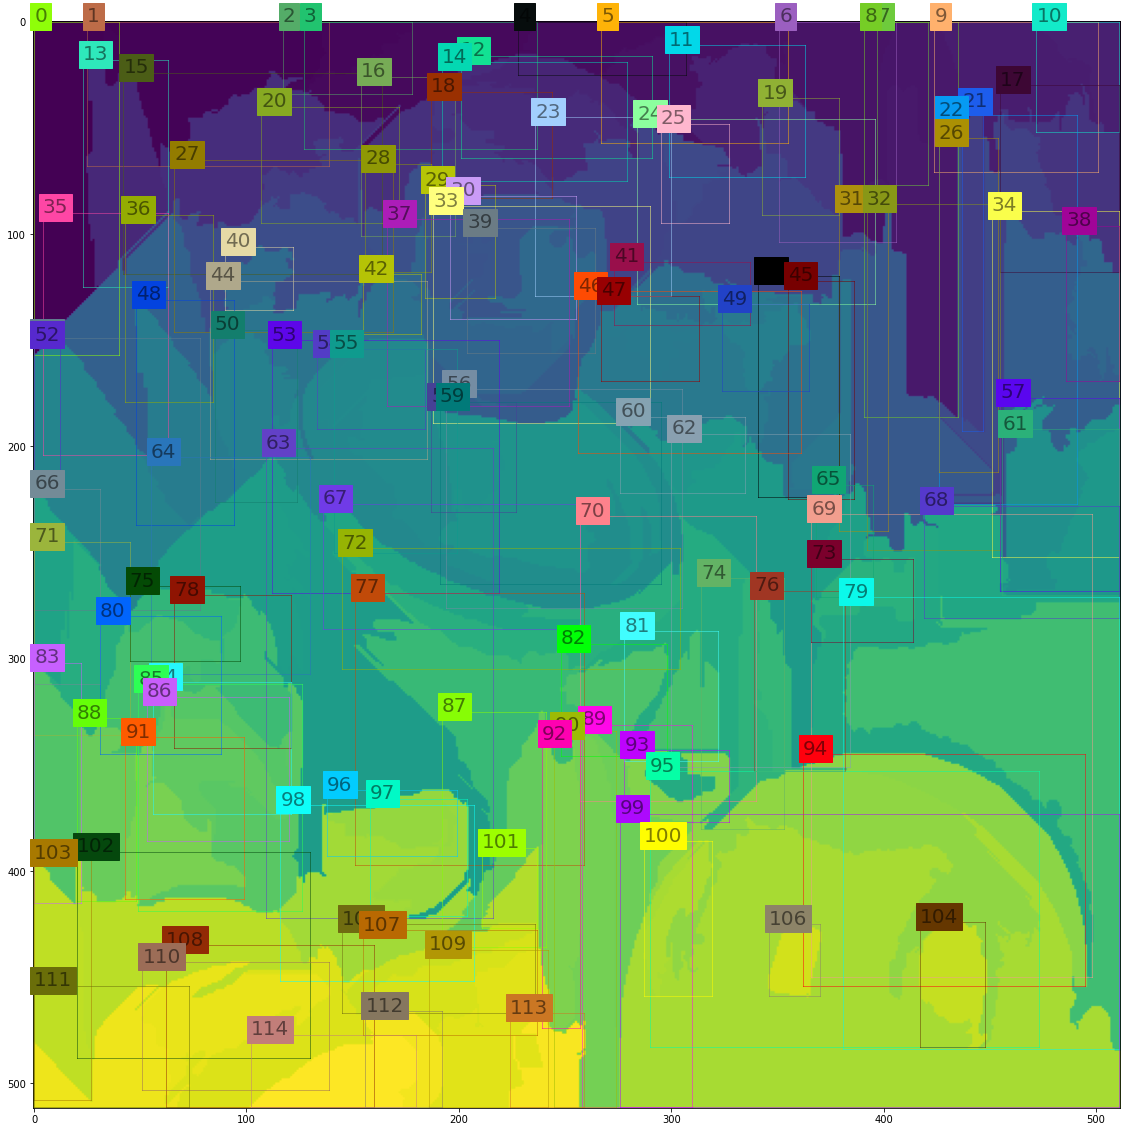

In [60]:
figsize = (20,20)
plt.figure(figsize=figsize)    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

plt.figure(figsize=figsize)    
plt.imshow(img[:,:,3])
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()


**Finding Binary Pattern**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


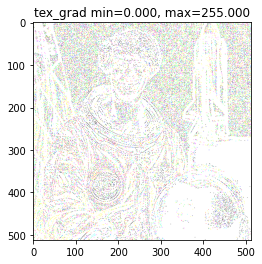

In [61]:
def calc_texture_gradient(img):
    """
        calculate texture gradient for entire image

        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.

        output will be [height(*)][width(*)]
    """
    ret = np.zeros(img.shape[:3])
    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def plot_image_with_min_max(img,nm):
    img = img[:,:,:3]
    plt.imshow(img)
    plt.title("{} min={:5.3f}, max={:5.3f}".format(nm,
                                                   np.min(img),
                                                   np.max(img)))
    plt.show()

tex_grad = calc_texture_gradient(img)   
plot_image_with_min_max(tex_grad,nm="tex_grad")

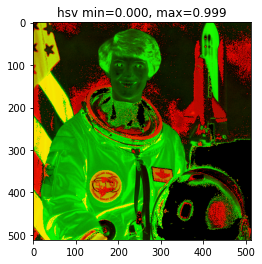

In [62]:
def calc_hsv(img):
    hsv = skimage.color.rgb2hsv(img[:,:,:3])
    return(hsv)

hsv = calc_hsv(img)
plot_image_with_min_max(hsv,nm="hsv")

In [0]:
def calc_hist(img, minhist=0, maxhist=1):
    """
        calculate colour histogram for each region

        the size of output histogram will be BINS * COLOUR_CHANNELS(3)

        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]

        extract HSV
        
        len(hist) = BINS * 3
        hist[:BINS] = [0, 10, 20, 0,...,0] meaning that 
           there are 10 pixels that have values between (maxhist - minhist)/BINS*1 and (maxhist - minhist)/BINS*2
           there are 10 pixels that have values between (maxhist - minhist)/BINS*2 and (maxhist - minhist)/BINS*3
    
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in range(3):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, 
                                   # The lower and upper range of the bins. 
                                   (minhist, maxhist))[0]])

    # L1 normalize
    hist = hist / len(img)
    return hist

def augment_regions_with_histogram_info(tex_grad, img, R,hsv,tex_trad):
    for k, v in list(R.items()):

        ## height and width axies are flattened. 
        ## masked_pixel.shape = (N pixel with this mask ID , 3)
        masked_pixels  = hsv[img[:, :, 3] == k] 
        R[k]["size"]   = len(masked_pixels / 4)
        R[k]["hist_c"] = calc_hist(masked_pixels,minhist=0, maxhist=1)

        # texture histogram
        R[k]["hist_t"] = calc_hist(tex_grad[img[:, :, 3] == k],minhist=0, maxhist=2**8-1)
    return(R)
R = augment_regions_with_histogram_info(tex_grad, img,R,hsv,tex_grad)

**Finding The Intesrsecting Region**

In [64]:
def extract_neighbours(regions):
    '''
    check if two regions intersect 
    '''

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"]) or\
           (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or\
           (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or\
           (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours

neighbours = extract_neighbours(R)
print("Out of {} regions, we found {} intersecting pairs".format(len(R),len(neighbours)))

Out of 115 regions, we found 387 intersecting pairs


In [0]:

def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize
def calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2)       +\
            _sim_texture(r1, r2)      +\
            _sim_size(r1, r2, imsize) +\
            _sim_fill(r1, r2, imsize))

def calculate_similarlity(img,neighbours,verbose=False):
    # calculate initial similarities
    imsize = img.shape[0] * img.shape[1]
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = calc_sim(ar, br, imsize)
        #if verbose:
            #print("S[({:2.0f}, {:2.0f})]={:3.2f}".format(ai,bi,S[(ai, bi)]))
    return(S)

#print("S[(Pair of the intersecting regions)] = Similarity index")
S = calculate_similarlity(img,neighbours,verbose=True)

**Merge Regions**

In [66]:

def merge_regions(r1, r2):
    '''
    Suppose r1 and r2 look like: 
    
    (minx1, miny1)
          _____________________
          |                   |
          |     (minx2,maxy2) |
          |           ________|____ 
          |          |        |    |
          |          |        |    |
          |          |________|____|(maxx2, maxy2)
          |___________________|(maxx1, maxy1)
          
    Then for merged region,
    
    minx : minx1
    miny : miny1
    maxx : maxx2
    maxy : maxy1 
    size : the number of pixels in the two regions (intersection is counted twice?)
    
                         
    '''
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt

def merge_regions_in_order(S,R,imsize, verbose=False):
    '''
    == Input ==
    S : similarity dictionary
    
    R : dictionary of proposed regions
    
    == Output ==
    
    regions : list of regions
    
    '''
    # hierarchal search
    while S != {}:

        # Step 1: get highest similarity pair of regions from the similarlity dictionary
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # Step 2: marge the region pair and add to the region dictionary
        t = max(R.keys()) + 1.0
        R[t] = merge_regions(R[i], R[j])

        # Step 3: from the similarity dictionary, 
        #         remove all the pair of regions where one of the regions is selected in Step 1
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)
        for k in key_to_delete:
            del S[k]

        # Step 4: calculate similarity with new merged region and the regions and its intersecting region
        #         (intersecting region is the region that are to be deleted)
        for k in key_to_delete:
            if k != (i,j):
                if k[0] in (i, j):
                    n = k[1]
                else:
                    n = k[0]
                S[(t, n)] = calc_sim(R[t], R[n], imsize)
    if verbose:
        print("{} regions".format(len(R)))

    ## finally return list of region proposal
    regions = []
    for k, r in list(R.items()):
            regions.append({
                'rect': (
                    r['min_x'],              # min x
                    r['min_y'],              # min y
                    r['max_x'] - r['min_x'], # width 
                    r['max_y'] - r['min_y']),# height
                'size': r['size'],
                'labels': r['labels']
            })
    return(regions)



regions = merge_regions_in_order(S,R,img.shape[0]*img.shape[1],verbose=True)

229 regions


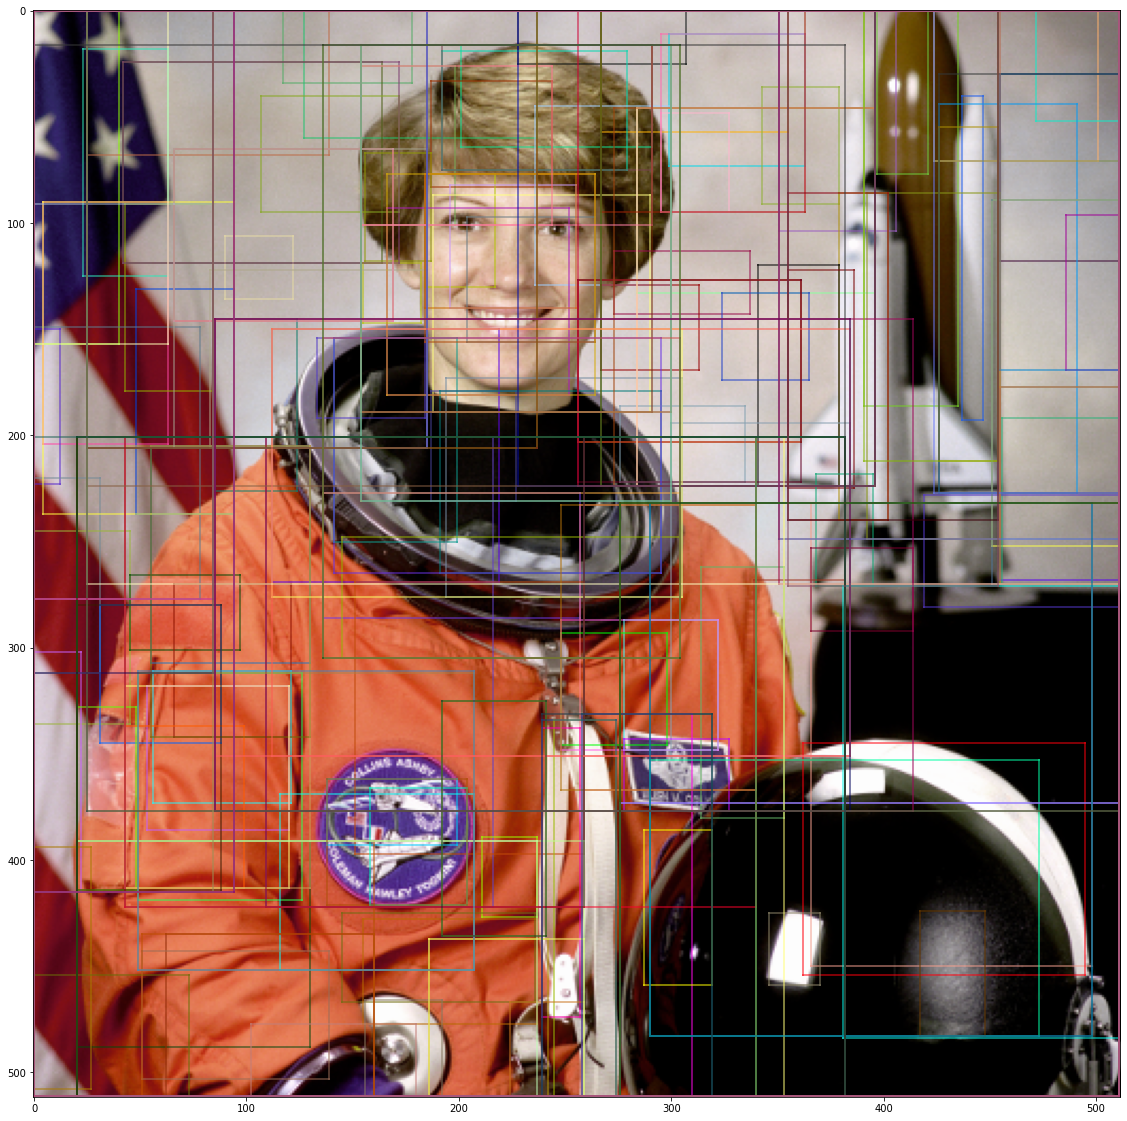

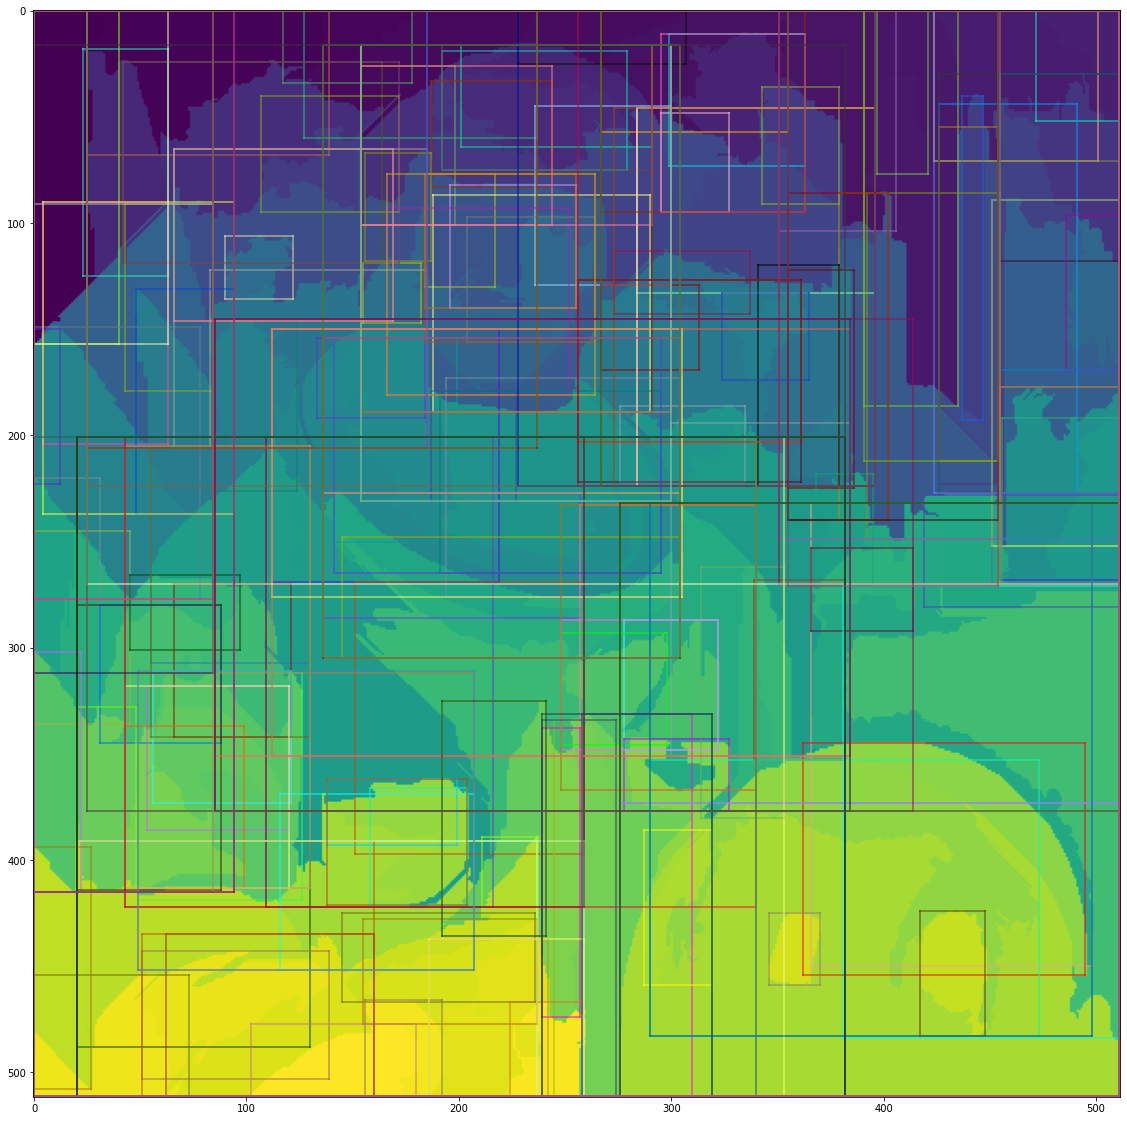

In [67]:
plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,x1,y1,x2 = x1 + width,y2 = y1 + height, color = color)
plt.show()

plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,3])
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,
                  x1,
                  y1,
                  x2 = x1 + width,
                  y2 = y1 + height, color= color)
plt.show()

129 regions are found


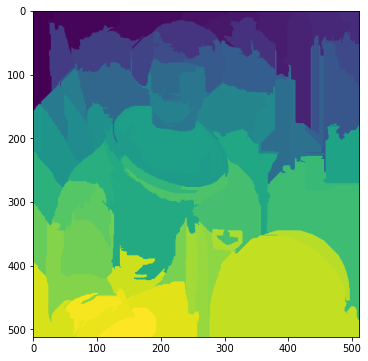

In [68]:
def get_region_proposal(img):
    R          = extract_region(img)    
    tex_grad   = calc_texture_gradient(img)
    hsv        = calc_hsv(img)
    R          = augment_regions_with_histogram_info(tex_grad, img, R,hsv,tex_grad)
    del tex_grad, hsv
    neighbours = extract_neighbours(R)
    S          = calculate_similarlity(img,neighbours)
    regions    = merge_regions_in_order(S,R,imsize = img.shape[0] * img.shape[1])
    return(regions)

img_float = skimage.util.img_as_float(image)
img_seg = felzenszwalb(img_float, scale=3, sigma=0.8, min_size=800)
import numpy as np
img = np.dstack([image,img_seg])
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img[:,:,3])

regions = get_region_proposal(img)
regions
print("{} regions are found".format(len(regions)))

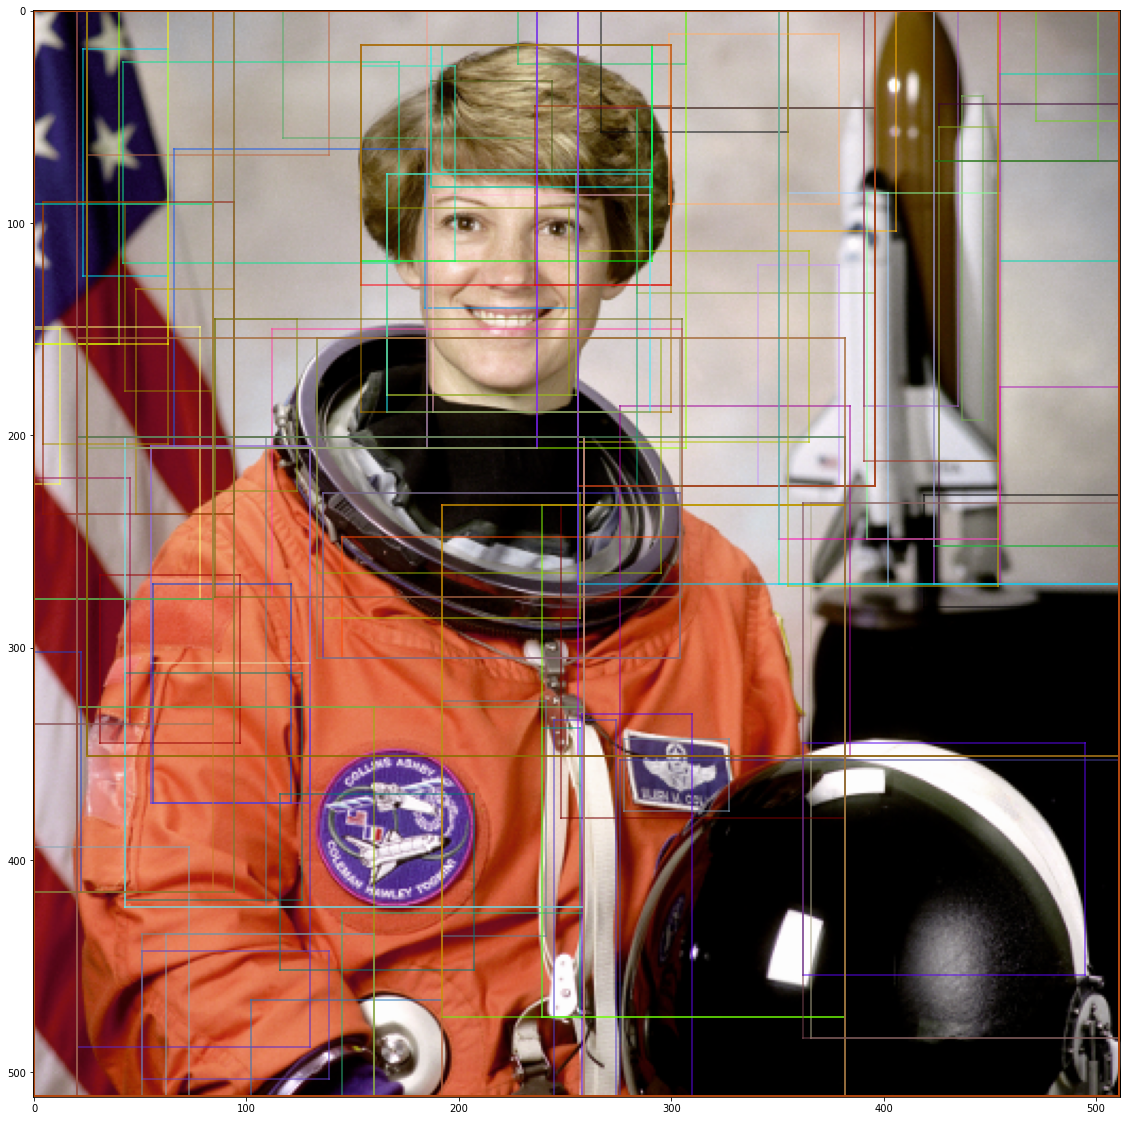

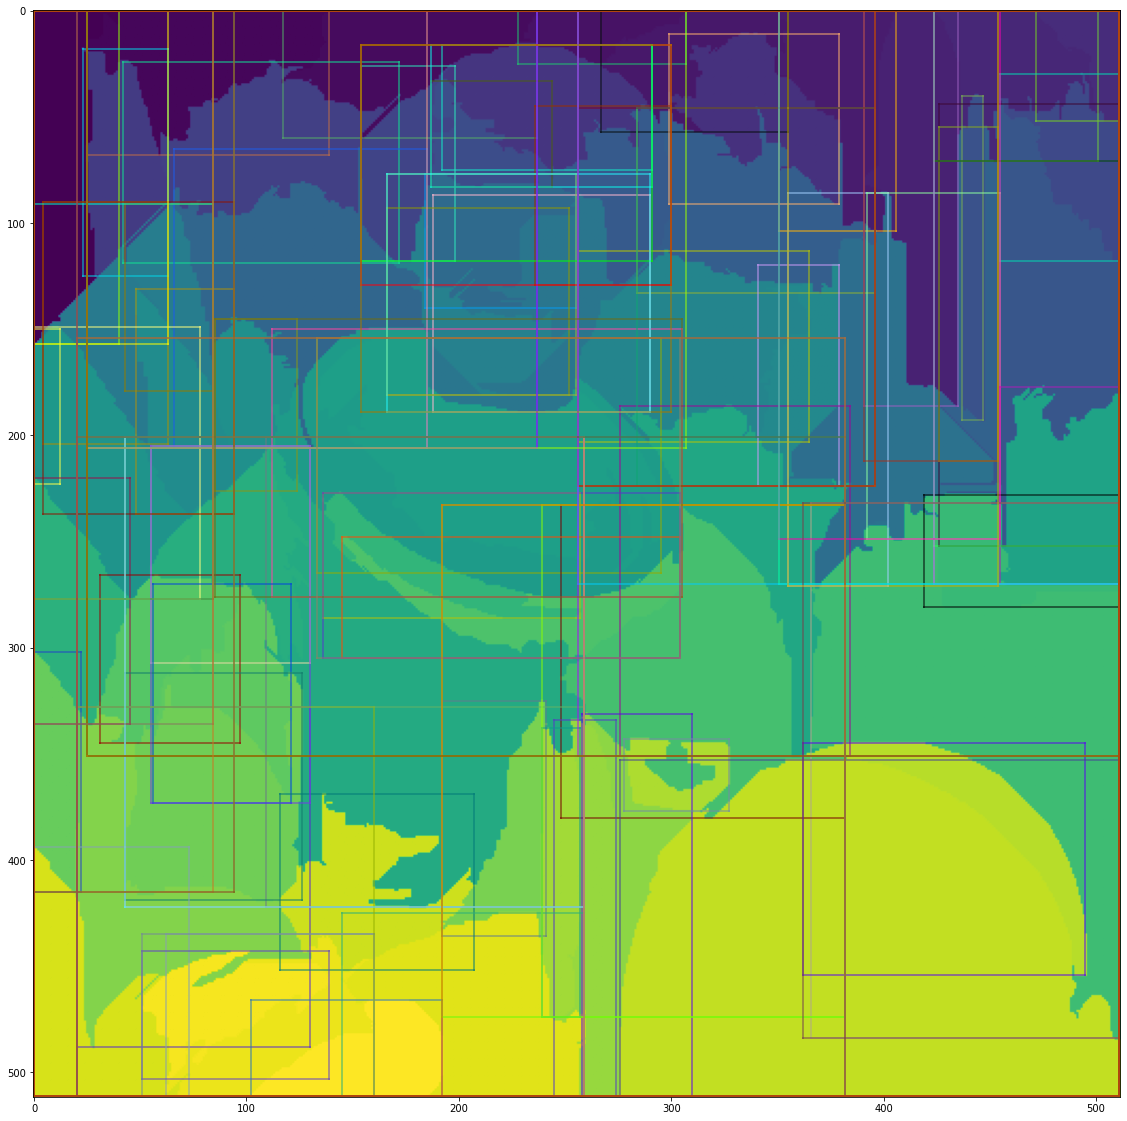

In [69]:
plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,x1,y1,x2 = x1 + width,y2 = y1 + height, color = color)
plt.show()

plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,3])
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,
                  x1,
                  y1,
                  x2 = x1 + width,
                  y2 = y1 + height, color= color)
plt.show()